<a href="https://colab.research.google.com/github/cemdaloglu/AML_project/blob/main/aml_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import random_split
import time
import torch
from tqdm import tqdm
import glob
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
from pathlib import Path
import time
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
from torchsummary import summary

In [ ]:
def get_dataloaders(train_dataset, val_dataset, dataloader_workers: int = 3, batch_size: int = 8):
    """
    Get Dataloaders for the given dataset.
    
    @param dataset The dataset to wrap into a Dataloader
    @param dataloader_workers How many workers to give each Dataloader.
    @param batch_size Batch Size
    """

    kwargs = {'pin_memory': True, 'num_workers': dataloader_workers}
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        **kwargs
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        drop_last=True,
        shuffle=True,
        **kwargs
    )
    return {
        'train': train_loader,
        'val': val_loader
    }

In [ ]:
def get_test_dataloaders(test_dataset, dataloader_workers: int = 3, batch_size: int = 8):
    """
    Get Dataloaders for the given dataset.

    @param test_dataset The dataset to wrap into a Dataloader
    @param dataloader_workers How many workers to give each Dataloader.
    @param batch_size Batch Size
    """

    kwargs = {'pin_memory': True, 'num_workers': dataloader_workers}
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        **kwargs
    )
    return test_loader

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)

In [ ]:
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return down_out, skip_out

In [ ]:
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpBlock, self).__init__()
        self.up_sample = nn.ConvTranspose2d(in_channels - out_channels, in_channels - out_channels, kernel_size=2,
                                            stride=2)
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x)

In [ ]:
class UNet(nn.Module):
    def __init__(self, out_classes=6):
        super(UNet, self).__init__()
        # Downsampling Path
        self.down_conv1 = DownBlock(4, 64)
        self.down_conv2 = DownBlock(64, 128)
        self.down_conv3 = DownBlock(128, 256)
        self.down_conv4 = DownBlock(256, 512)
        # Bottleneck
        self.dropout = nn.Dropout(0.25)
        self.double_conv = DoubleConv(512, 1024)
        # Upsampling Path
        self.up_conv4 = UpBlock(512 + 1024, 512)
        self.up_conv3 = UpBlock(256 + 512, 256)
        self.up_conv2 = UpBlock(128 + 256, 128)
        self.up_conv1 = UpBlock(128 + 64, 64)
        # Final Convolution
        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)
        self.m = nn.Softmax(dim=1)

    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)
        x = self.dropout(x)
        x = self.double_conv(x)
        x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)
        x = self.conv_last(x)
        x = self.m(x)
        return x

In [ ]:
def calc_loss(target, pred, criterion, metrics):
    '''
    TODO: THINK ABOUT NICE LOSS AND ALSO WEIGHTS
    '''
    if criterion == "CEL":
        loss = nn.CrossEntropyLoss()
    elif criterion == "wCEL":
        loss = nn.CrossEntropyLoss() # TODO
    else:
        loss = nn.CrossEntropyLoss()
 
    loss = loss(target, pred.long())
    """if metrics is not None:
        metrics['loss'] += loss.data.cpu().numpy() * target.size(0) # TODO probably add f1 stuff"""

    return loss

In [ ]:
def train_model(model, dataloaders, use_cuda, optimizer, num_epochs, checkpoint_path_model, loss_criterion: str,
                trained_epochs: int = 0):
    best_loss = 1e10
    total_acc = {key: [] for key in ['train', 'val']}
    total_loss = {key: [] for key in ['train', 'val']}

    # iterate over all epochs
    for epoch in range(trained_epochs, num_epochs):
        print(f'Epoch {epoch}/{num_epochs}')
        print('-' * 10)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            metrics = defaultdict(float)
            epoch_samples = 0

            for dic in tqdm(dataloaders[phase], total=len(dataloaders[phase])):
                inputs, labels = dic['image'], dic['mask']

                if use_cuda:
                    inputs = inputs.to('cuda', dtype=torch.float)  # [batch_size, in_channels, H, W]
                    labels = labels.to('cuda', dtype=torch.long)

                optimizer.zero_grad()  # zero the parameter gradients

                epoch_accuracy = 0
                epoch_loss = 0
                # forward pass: compute prediction and the loss btw prediction and true label
                # track history only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)

                    # output is probability [batch size, n_classes, H, W], target is class [batch size, H, W]
                    # TODO: decide on loss!! (dummy function here)
                    loss = calc_loss(outputs, labels, loss_criterion, metrics)

                    # backward + optimize only if in training phase (no need for torch.no_grad in this training pass)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    epoch_loss += loss

                # statistics
                epoch_samples += inputs.size(0)

                acc = ((outputs.argmax(dim=1) == labels).float().mean())
                epoch_accuracy += acc / len(dataloaders[phase])
                epoch_loss += loss / len(dataloaders[phase])
            print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy, epoch_loss))
            total_acc[phase].append(epoch_accuracy)
            total_loss[phase].append(epoch_loss)

            epoch_loss = loss / epoch_samples
            print("epoch_loss = ", epoch_loss)

            # save the model weights in validation phase 
            if phase == 'val':
                if epoch_loss < best_loss:
                    print(f"saving best model to {checkpoint_path_model}")
                    best_loss = epoch_loss
                    torch.save(model.state_dict(), checkpoint_path_model)

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(torch.load(checkpoint_path_model))
    return model, total_loss, total_acc


In [ ]:
def plot_training(total_loss, total_acc):
    total_loss_train = []
    for idx in range(len(total_loss['train'])):
        total_loss_train.append(total_loss['train'][idx].detach().cpu().numpy())

    total_loss_val = []
    for idx in range(len(total_loss['val'])):
        total_loss_val.append(total_loss['val'][idx].detach().cpu().numpy())

    total_acc_train = []
    for idx in range(len(total_acc['train'])):
        total_acc_train.append(total_acc['train'][idx].detach().cpu().numpy())

    total_acc_val = []
    for idx in range(len(total_acc['val'])):
        total_acc_val.append(total_acc['val'][idx].detach().cpu().numpy())

    plt.plot(total_loss_train, color='blue')
    plt.plot(total_loss_val, color='orange')
    plt.title("Loss")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['train_loss', 'valid_loss'])
    plt.show()

    plt.plot(total_acc_train, color='blue')
    plt.plot(total_acc_val, color='orange')
    plt.title("Accuracy")
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['train_acc', 'val_acc'])
    plt.show()

In [ ]:
import seaborn as sn

def get_project_root() -> Path:
    """ return path to the project root"""
    return Path(__file__).parent


def test(model, test_loader, use_cuda: bool, loss_criterion=None, n_classes = 5):
    """
    Compute test metrics on test data set 

    @param model: -- the neural network
    @param: use_cuda: -- true if GPU should be used
    @param: loss_fun: -- the used loss function from calc_loss
    @param: test_loader: -- test data dataloader
    @param: test_batch_size: -- used batch size
    """
    model.eval()
    labels = np.arange(n_classes)
    conf_matrix = np.zeros((n_classes, n_classes))

    # initialize all variables 
    num_correct = 0
    num_pixels = 0
    all_images = []
    all_labels = []
    all_predictions = []
    test_losses = []

    with torch.no_grad():
        acc = 0
        pre = 0
        recall = 0
        f1 = 0
        for batch_index, dic in tqdm(enumerate(test_loader), total=len(test_loader)):
            images, labels = dic['image'], dic['mask']

            all_images.extend(images.cpu())
            all_labels.extend(labels.cpu())

            if use_cuda:
                images = images.to('cuda', dtype=torch.float)
                labels = labels.to('cuda', dtype=torch.int)

            # run network
            prediction = model(images)  # torch.Size([batch_size, n_classes, h, w])

            # compute and save loss
            test_loss = calc_loss(prediction, labels.long(), criterion=loss_criterion, metrics = defaultdict(float))
            test_losses.extend(test_loss.cpu().numpy().reshape(-1))

            # take argmax to get class 
            final_prediction = torch.argmax(prediction.softmax(dim=1), dim=1)  # torch.Size([batch_size, h, w])

            for j in range(len(labels)):
                true_label = labels[j].cpu().detach().numpy().flatten()
                pred_label = final_prediction[j].cpu().detach().numpy().flatten()
                conf_matrix += confusion_matrix(true_label, pred_label, labels=[0, 1, 2, 3, 4, 5]) / len(test_loader)  # TODO: maybe use to compute IoU (Intersection over Union)

            all_predictions.extend(final_prediction.cpu())

            # Compute number of correct predictions 
            num_correct += (final_prediction == labels).sum()
            num_pixels += torch.numel(final_prediction)

            #   calculate accuracy
            acc += accuracy_score(true_label, pred_label) / len(test_loader)
            #   calculate precision
            pre += precision_score(true_label, pred_label, average='macro', zero_division=1) / len(test_loader)
            #   calculate recall
            recall += recall_score(true_label, pred_label, average='macro', zero_division=1) / len(test_loader)
            #   calculate F1 score
            f1 += f1_score(true_label, pred_label, average='macro') / len(test_loader)
    print('Loss of best validation batch:', np.min(test_losses))

    losses_per_instance = pd.DataFrame(data={'loss': test_losses})

    # print metrics
    print("Mean Loss:", np.mean(test_losses), "\nMean Acc:", acc, "\nMean Macro Precision:", pre,
          "\nMean Macro Recall:", recall,
          "\nMean Macro F1 Score:", f1)

    # plot confusion matrix
    df_cm = pd.DataFrame(conf_matrix, index=["unknown",  "agriculture", "forest", "city", "wetlands", "water"],
                     columns=["unknown",  "agriculture", "forest", "city", "wetlands", "water"])
    plt.figure(figsize=(10, 7))
    sn.heatmap(df_cm, annot=True)

    test_accuracy = (num_correct / num_pixels * 100).cpu().numpy()
    print(f"Got {num_correct}/{num_pixels} with acc {test_accuracy}")

In [ ]:
import os
from matplotlib.transforms import Transform

import numpy as np
import torch
from torch.utils.data import Dataset
from skimage.io import imread
import glob

class CityData(Dataset):

    def __init__(self, train_test_path, transforms = None):
        """
        train_test_path -- path to either "train", "val", or "test" containing subfolders 'images' and 'masks' where the patched data lies, e.g. ../patches/train
        transform -- transform (from torchvision.transforms) to be applied to the data

        Usage: citydata = CityData(train_test_path)
        """
        self.transforms = transforms
        self.images = []
        self.labels = []

        # Define Dataset 
        self.patch_imgs_path = sorted(glob.glob(train_test_path + 'images/*'))
        self.patch_masks_path = sorted(glob.glob(train_test_path + 'masks/*'))
        self.transforms = transforms

    def __len__(self):
        """
        return the number of total samples contained in the dataset
        """
        return len(self.patch_imgs_path)

    def __getitem__(self, idx): 
        """ 
        Return the examples at index [idx]. The example is a dict with keys 
        - 'images' value: Tensor for an RGB image of shape 
        - 'mask' value: ground truth labels 0,..., n_classes of shape
        - 'img_idx' value: index of sample
        """

        image = np.load(self.patch_imgs_path[idx])
        mask = np.load(self.patch_masks_path[idx])

        """image = []
        for image_path in glob.glob(f"{self.patch_imgs_path}/*.npy"):
          image.append(np.load(image_path))

        mask = []
        for image_path in glob.glob(f"{self.patch_masks_path}/*.npy"):
          mask.append(np.load(image_path))"""
        
        # To tensor 
        #image = torch.from_numpy(image) 
        #mask = torch.from_numpy(mask)    

        #preprocessed image, for input into NN
        sample = {'image':image, 'mask':mask, 'img_idx':idx}

        if self.transforms:
            sample = self.transforms(sample)

        return sample

In [ ]:
#train_dataset = np.load("/content/drive/MyDrive/train_set.npy", allow_pickle=True)
test_dataset = np.load("/content/drive/MyDrive/test_set.npy", allow_pickle=True)
val_dataset = np.load("/content/drive/MyDrive/val_set.npy", allow_pickle=True)

In [ ]:
"""train_set = CityData(os.path.join("/content/drive/MyDrive/patches_new/patches/", 'train/'))
val_set = CityData("/content/drive/MyDrive/patches_new/patches/val/") 
test_set = CityData(os.path.join("/content/drive/MyDrive/patches_new/patches/", 'test/'))

train_dataset = []
for idx in range(train_set.__len__()):
    train_dataset.append(train_set.__getitem__(idx))

val_dataset = []
for idx in range(val_set.__len__()):
    val_dataset.append(val_set.__getitem__(idx))

test_dataset = []
for idx in range(test_set.__len__()):
    test_dataset.append(test_set.__getitem__(idx))"""

'train_set = CityData(os.path.join("/content/drive/MyDrive/patches_new/patches/", \'train/\'))\nval_set = CityData("/content/drive/MyDrive/patches_new/patches/val/") \ntest_set = CityData(os.path.join("/content/drive/MyDrive/patches_new/patches/", \'test/\'))\n\ntrain_dataset = []\nfor idx in range(train_set.__len__()):\n    train_dataset.append(train_set.__getitem__(idx))\n\nval_dataset = []\nfor idx in range(val_set.__len__()):\n    val_dataset.append(val_set.__getitem__(idx))\n\ntest_dataset = []\nfor idx in range(test_set.__len__()):\n    test_dataset.append(test_set.__getitem__(idx))'

In [ ]:
for idx in range(test_dataset.size):
    test_dataset[idx]['mask'] = np.int32(test_dataset[idx]['mask'])

In [ ]:
for idx in range(val_dataset.size):
    val_dataset[idx]['mask'] = np.int32(val_dataset[idx]['mask'])

In [ ]:
data_loaders = get_dataloaders(test_dataset, val_dataset, batch_size=16)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
for idx in range(data_loaders['train'].dataset.size):
    data_loaders['train'].dataset[idx]['image'] = np.reshape(data_loaders['train'].dataset[idx]['image'], (4, 128, 128))

In [ ]:
for idx in range(data_loaders['val'].dataset.size):
    data_loaders['val'].dataset[idx]['image'] = np.reshape(data_loaders['val'].dataset[idx]['image'], (4, 128, 128))

In [ ]:
# Pick your hyper parameters
epoch_count = 2
train_val_batch = 16
test_batch = 16
learning_rate = 0.01
weight_decay = 0.001

# initialize your network
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet()
model = model.to(device, dtype=torch.float)
#summary(model, input_size=(4, 64, 64))

optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=weight_decay)
use_cuda = torch.cuda.is_available()
trained_model, total_loss, total_acc = train_model(model=model, dataloaders=data_loaders, use_cuda=use_cuda, optimizer=optimizer,
                            num_epochs=epoch_count, loss_criterion="CEL", checkpoint_path_model="best_unet.pth")

Epoch 0/2
----------


  0%|          | 0/231 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 231/231 [00:58<00:00,  3.97it/s]


Epoch : 1, train accuracy : 0.002746846294030547, train loss : 1.4140660762786865
epoch_loss =  tensor(0.0004, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 159/159 [00:13<00:00, 11.94it/s]


Epoch : 1, train accuracy : 0.004319820553064346, train loss : 1.367431640625
epoch_loss =  tensor(0.0005, device='cuda:0')
saving best model to best_unet.pth
1m 12s
Epoch 1/2
----------


100%|██████████| 231/231 [00:57<00:00,  4.02it/s]


Epoch : 2, train accuracy : 0.0029055278282612562, train loss : 1.3790303468704224
epoch_loss =  tensor(0.0004, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 159/159 [00:13<00:00, 11.96it/s]


Epoch : 2, train accuracy : 0.004420178476721048, train loss : 1.3555641174316406
epoch_loss =  tensor(0.0005, device='cuda:0')
saving best model to best_unet.pth
1m 11s
Best val loss: 0.000530


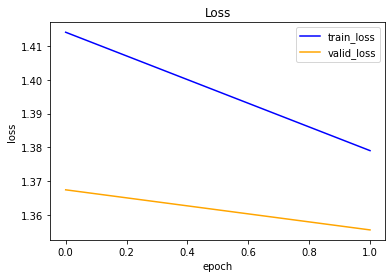

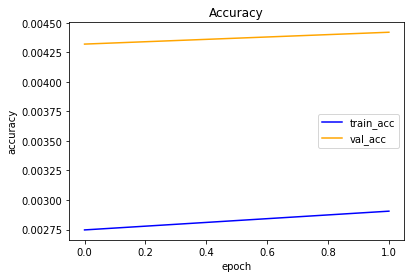

In [ ]:
plot_training(total_loss, total_acc)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 231/231 [00:31<00:00,  7.39it/s]


Loss of best validation batch: 1.2557576
Mean Loss: 1.399528 
Mean Acc: 0.671535739650974 
Mean Macro Precision: 0.7419416048656038 
Mean Macro Recall: 0.3978101167863505 
Mean Macro F1 Score: 0.3236476500502068
Got 38959781/60555264 with acc 64.33756256103516


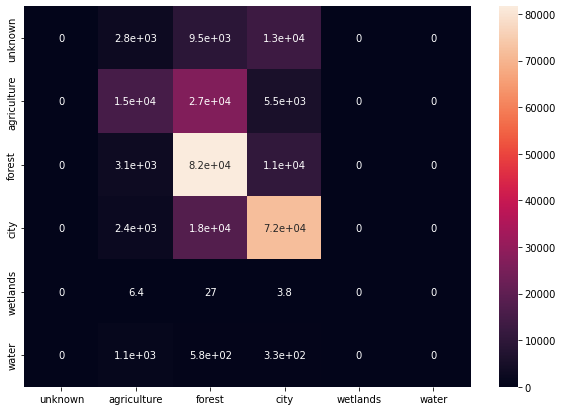

In [ ]:
test_loader = get_test_dataloaders(test_dataset=test_dataset, batch_size=test_batch)

test(model=trained_model, use_cuda=True, test_loader=test_loader, n_classes=6, loss_criterion="CEL")